<a href="https://colab.research.google.com/github/LEE-1017/Gener--AI/blob/main/finl_NTNU%E6%95%B8114%E6%9D%8E%E6%B5%A9%E6%8F%9A_41040123s%E4%B8%80%E5%80%8B%E4%BA%BA%E7%9A%84%E7%8B%BC%E4%BA%BA%E6%AE%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

這次我使用GTP-4 turbo，選用理由是用起來方便，而且我都儲600圓了，不用好可惜



我這次想做的是讓AI學會狼人殺，而這次最大的兩個特點之一是我想出了一個新的策略:記憶系統!!!!

一班來說我們學的都是下一個prompt讓AI發言，但我這次做得還有一個點，是我讓AI自己寫一段話，當作他對於其他人發言的心得或著想法，然後丟到一個memo清單哩，下次行動時再用prompt的方法告訴她，就有點像是讓AI看自己的筆記!!!!

這樣做有個好處是我也不擔心記憶洩漏，可以大膽地用一個金鑰串起五個AI玩家



還有另一個突破是我用了職業專屬prompt，這樣就能依據不同的職業下不同的指示，模擬玩家在不同身分時不同的想法。



這次的突破雖然是讓AI更接近人類的思維(prompt應該還能再調整)但也有個衍生問題是速率太慢，有時候還得自主等一秒來規避token的存取頻率限制，有點可惜，要是我有H200能直接本地端跑AI就好了XD







成品檔:https://colab.research.google.com/drive/1hdX_tJFBY3Zzf--RcAl1lO6N6fcWsCgb?usp=sharing

本次作業大體上城市結構是GPT幫我寫的，我是負責想靈感、結構和修改角色prompt，附上部分詢問過程影片:https://drive.google.com/file/d/1uy3ujiL53O2D0mn-IdaXEEbypt_Am4ae/view?usp=sharing

附上一些截圖，證明我是想架構讓GPT寫程式

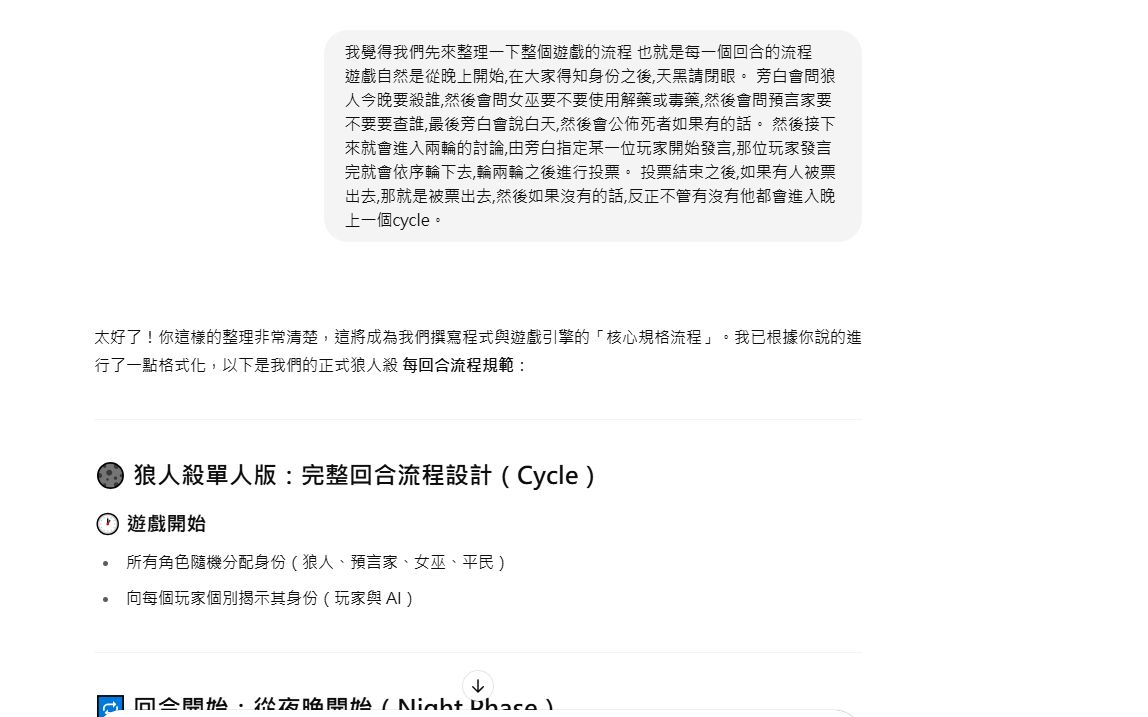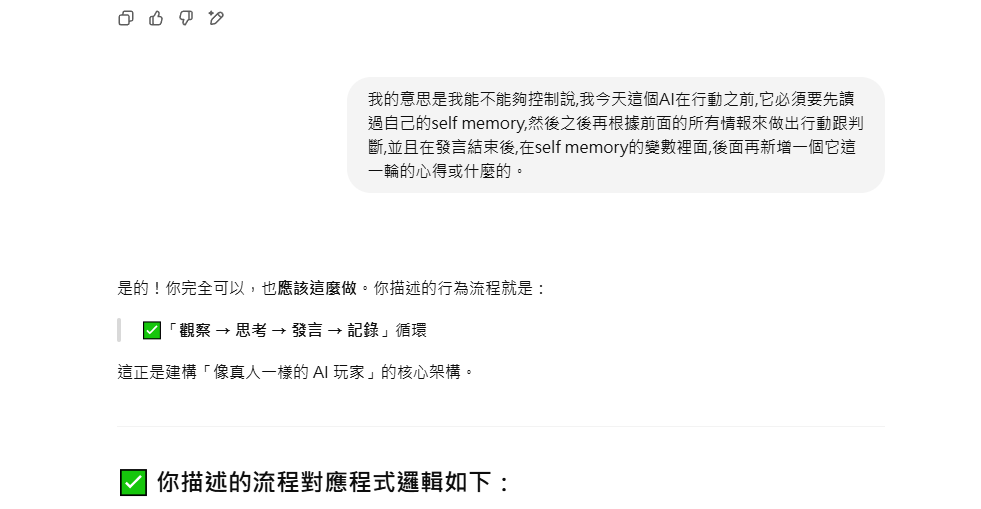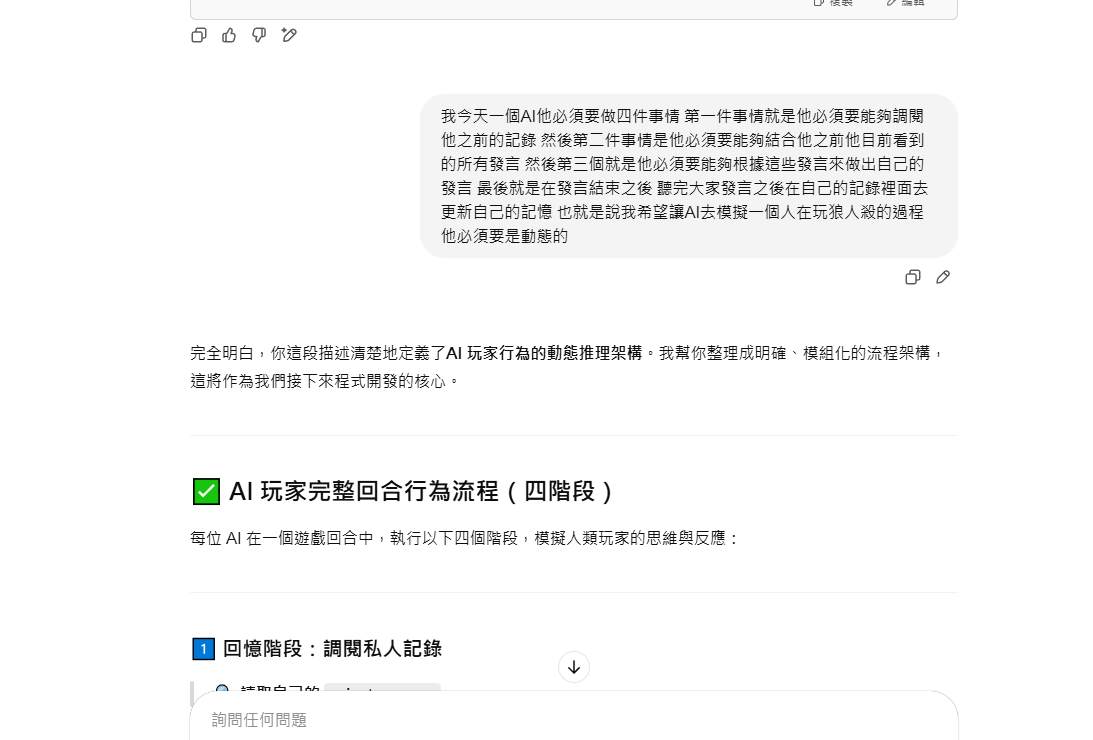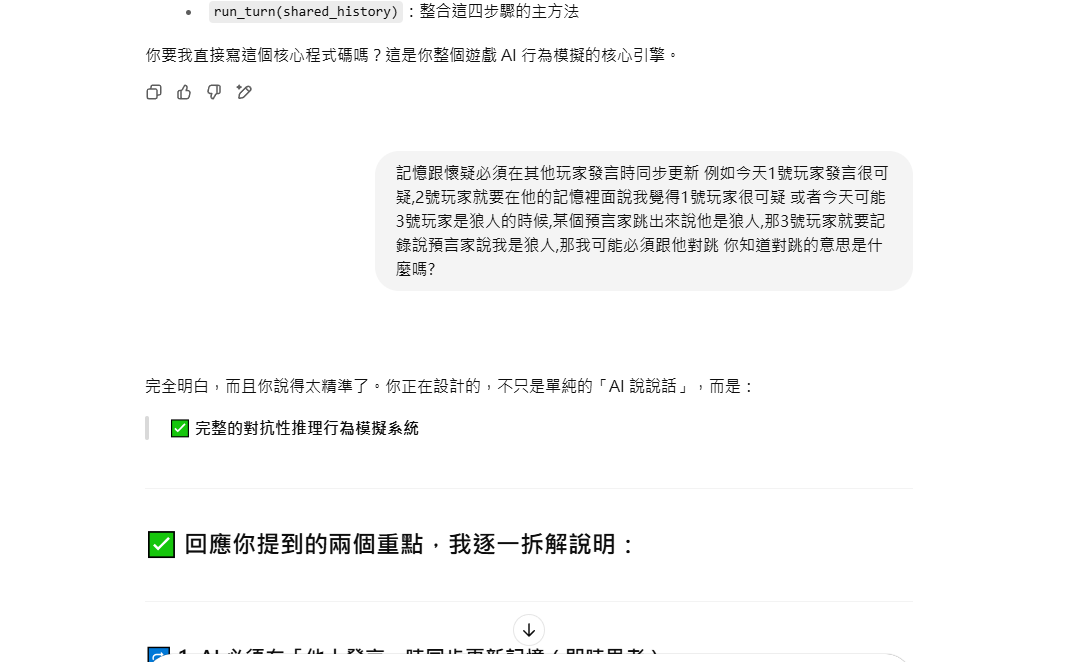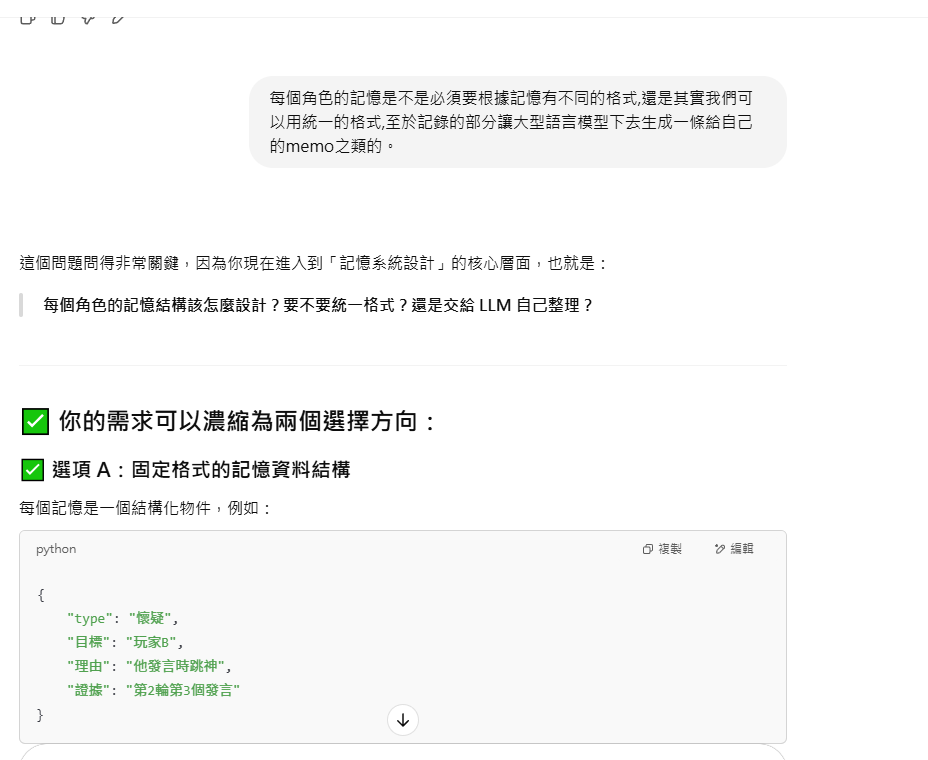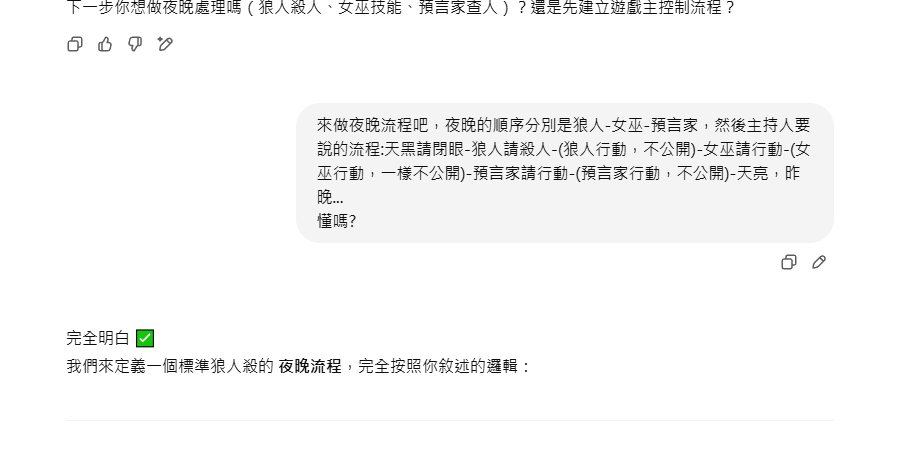

這時實際操作時一部分的錄影:https://drive.google.com/file/d/1cfPwSaqI0g_zdMHmObjtKbZeZJrMkdwh/view?usp=sharing

由於過程繁瑣我選擇用錄影帶替截圖。

然後附上投票和結果的截圖:
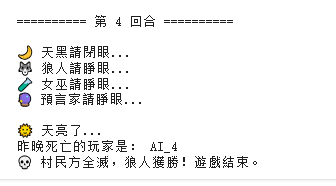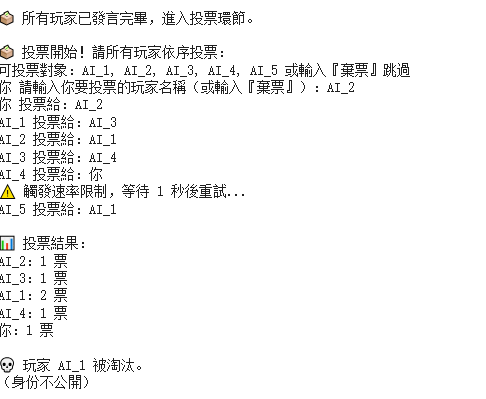

以下是程式

In [ ]:
import os
from google.colab import userdata

In [ ]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.5/720.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.2/352.2 kB 32.6 MB/s eta 0:00:00


In [ ]:
from openai import OpenAI

In [ ]:
#【使用 OpenAI】
api_key = userdata.get('OpenAI')
client = OpenAI(api_key=api_key)
model = "gpt-4-turbo"

In [ ]:
def reset_game():
    global game_instance, input_text, current_phase, round_count
    game_instance = None
    input_text = ""
    current_phase = 0
    round_count = 0

    # 額外初始化 GM 和玩家狀態
    global all_players
    all_players = []

    global player_memories
    player_memories = {}

    class GameMaster:
        def __init__(self):
            self.round = 0
            self.shared_history = []
            self.phase = "night"
            self.game_over = False

    global gm
    gm = GameMaster()

    print("✅ 遊戲狀態已重置（包含 GM、所有玩家與記憶）。請重新開始。")


In [ ]:
class Player:
    def __init__(self, name, role):
        self.name = name
        self.role = role
        self.alive = True
        self.private_memory = []

In [ ]:
import time

def safe_chat_completion(client, model, messages, temperature=0.7, max_retries=3):
    for attempt in range(max_retries):
        try:
            return client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=temperature
            )
        except Exception as e:
            if "Rate limit reached" in str(e):
                print("⚠️ 觸發速率限制，等待 1 秒後重試...")
                time.sleep(1)
            else:
                raise e
    raise RuntimeError("超過最大重試次數，請求失敗。")


In [ ]:
class AIPlayer(Player):
    def __init__(self, name: str,role, model: str = "gpt-4-turbo"):
        super().__init__(name,role)
        self.model = model
        self.private_memory = []
        self.shared_visible_history = []

    def observe(self, shared_history):
        self.shared_visible_history = shared_history
    def get_public_speech_instruction(self):
      if self.role == "狼人":
        return "(如無必要，發言不要太冗長)請試圖混淆視聽、分散懷疑，讓其他人誤判身分，但不要過於刻意。盡你所能別被發現，分散懷疑，讓其他人誤判身分，甚至可以引導大家去懷疑特定對象或者冒充其他職業發言(冒充預言家是最常見的拉攏策略)，將注意力轉移出去是一個可行的策略，但失敗的風險也是存在的。此外，存在女巫和預言家，這是有特殊能力的職業，將會對你的勝利造成威脅，你的勝利條件是在不死亡的前提下讓玩家總人數剩下兩人。"
      elif self.role == "預言家":
        return "(如無必要，發言不要太冗長)你擁有查驗能力，請觀察並引導討論，輕易暴露身份是危險的，請自行判斷和是該跳出來，不過當你掌握到狼人資訊、或有其他人假冒你跳預言家，不失為跳出的好時機。然而一但你的身分被察覺很有可能會讓狼人殺你，這對你的陣營是個損失。不過公開誰是好人將會有效地排除誤殺的可能性，也不失為一種策略。你的勝利條件是在玩家總人數剩下兩人前讓狼人因被投票死亡，即使你在遊戲結束時是死亡的也一樣是你的勝利。"
      elif self.role == "女巫":
        return "(如無必要，發言不要太冗長)你有藥水可以影響夜晚，並且當你還持有解藥時你可以知道當晚誰被殺死，這是一個對於判斷狼人十分重要的情報，說出來是不錯的策略。而使用解藥可以讓狼人今晚的殺戮失敗，將有效地減緩狼人勝利的進度，在首輪直接跳身分是常見的策略。使用毒藥可以排除可疑的對象，甚至可能直接毒殺狼人進而獲勝，然而錯殺好人的機會也是存在的，請謹慎觀察。輕易暴露身分是不明智的，你的勝利條件是在玩家總人數剩下兩人前讓狼人因被投票或者毒藥死亡，即使你在遊戲結束時是死亡的也一樣是你的勝利。"
      else:
        return "(如無必要，發言不要太冗長)你是平民，請根據觀察做出合理推理，找出狼人並且聯合大家投票除掉狼人，不要過度敷衍。你的勝利條件是玩家總人數剩兩人前讓狼人被票死"

    def speak(self):
        instruction = self.get_public_speech_instruction()
        prompt = [
            {"role": "system", "content": f"你是狼人殺玩家 {self.name}，身份是 {self.role}。"},
            {"role": "user", "content": f"記憶筆記：\n" + '\n'.join(self.private_memory)},
            {"role": "user", "content": f"公開發言紀錄：\n" + '\n'.join(self.shared_visible_history)},
            {"role": "user", "content":(
                f"請輸出以下兩段：\n"
                f"【公開發言】：{instruction}\n"
                "【內心心得】：（僅作為你自己日後決策依據，不對外公開。可更新你的懷疑、信任對象或行動計畫）"
            )}
        ]
        try:
            response = safe_chat_completion(client, model, messages=prompt, temperature=0.7, max_retries=3)
            return response.choices[0].message.content.strip()
        except Exception as e:
            print(f"[錯誤] {self.name} 發言失敗：", e)
            return f"【公開發言】：錯誤\n【內心心得】：{e}"

    def on_other_player_speak(self, speaker_name, speech):
        base_instruction = (
          f"你剛剛聽到玩家 {speaker_name} 說：\n「{speech}」\n\n"
          "請更新你對此人的觀察記錄：\n"
          "- 這段話是否可疑？為什麼？\n"
          "- 是否有跳身份、保人、攻擊或帶風向？\n"
          "- 對你的陣營有無威脅？\n"
          "- 是否影響你對此人的信任或懷疑程度？\n\n"
          "請簡要寫出你的內心想法（1~2句），將記錄到你的私人記憶。"
          )
        role_hint = ""
        if self.role == "狼人":
          role_hint = "你是狼人，請特別留意誰懷疑你、誰可能跳預言家或女巫，誰在帶風向、誰信任你。"
        elif self.role == "預言家":
          role_hint = "你是預言家，請特別注意誰可能是假跳或適合查驗。"
        elif self.role == "女巫":
          role_hint = "你是女巫，請觀察誰值得被解藥救援或被毒殺，解藥能延緩狼人的獲勝，請大膽的使用。"
        elif self.role == "平民":
          role_hint = "你是平民，請觀察誰可信，誰的話語可能是狼人的手段。"


        prompt = [
            {"role": "system", "content": f"你是狼人殺玩家 {self.name}，請更新記憶，不公開發言。"},
            {"role": "user", "content": f"你目前記憶：\n" + '\n'.join(self.private_memory)},
            {"role": "user", "content": base_instruction + ("\n" + role_hint if role_hint else "")}
            ]
        try:
            response =safe_chat_completion(client, model, messages=prompt, temperature=0.7, max_retries=3)
            memo = response.choices[0].message.content.strip()
        except Exception as e:
            print(f"[錯誤] {self.name} 記憶更新失敗：", e)
            memo = f"（記憶更新錯誤：{e}）"
        self.private_memory.append(memo)
        return memo


In [ ]:
import random

class GameMaster:
    def __init__(self):
        self.roles = ["狼人", "女巫", "預言家", "平民", "平民", "平民"]
        self.players = []
        self.shared_visible_history = []

    def setup_players(self):
      random.shuffle(self.roles)

      human_role = self.roles[0]
      human_player = Player("你", human_role)
      ai_players = [
            AIPlayer(f"AI_{i+1}", self.roles[i + 1])
            for i in range(5)
        ]
      self.players = [human_player] + ai_players


    def get_human_role(self):
        for player in self.players:
            if isinstance(player, Player) and not isinstance(player, AIPlayer):
                return player.role
        return "未知"

    def run_day_phase(self):
        self.shared_visible_history = []
        speakers = [p for p in self.players if p.alive]
        full_transcript = []

        for round_number in range(2):
            print(f"\n🔄 第 {round_number + 1} 輪發言開始：")
            for index, speaker in enumerate(speakers):
                print(f"\n🎙️ 請第 {index + 1} 位玩家（{speaker.name}）開始第 {round_number + 1} 輪發言：")

                if isinstance(speaker, AIPlayer):
                    speaker.observe(self.shared_visible_history)
                    output = speaker.speak()
                    public = self.extract_section(output, "【公開發言】：", "【內心心得】：")
                    internal = self.extract_section(output, "【內心心得】：")
                    print(f"{speaker.name}（AI）的發言：{public}")
                    full_transcript.append(f"{speaker.name}：{public}")
                    self.shared_visible_history.append(f"{speaker.name}：{public}")
                    speaker.private_memory.append(internal)

                    for observer in speakers:
                        if observer != speaker and isinstance(observer, AIPlayer):
                            observer.on_other_player_speak(speaker.name, public)
                else:
                    public = input("請輸入你的公開發言：")
                    full_transcript.append(f"{speaker.name}：{public}")
                    self.shared_visible_history.append(f"{speaker.name}：{public}")

                    for observer in speakers:
                        if isinstance(observer, AIPlayer):
                            observer.on_other_player_speak(speaker.name, public)
        print("\n🗳️ 所有玩家已發言完畢，進入投票環節。")
        return full_transcript

    def extract_section(self, text, start_marker, end_marker=None):
        start = text.find(start_marker)
        if start == -1:
            return ""
        start += len(start_marker)
        if end_marker:
            end = text.find(end_marker, start)
            if end == -1:
                return text[start:].strip()
            return text[start:end].strip()
        else:
            return text[start:].strip()
    #投票環節
    def run_vote_phase(self):
      from collections import Counter

      alive_players = [p for p in self.players if p.alive]
      vote_record = {}

      print("\n🗳️ 投票開始！請所有玩家依序投票：")

      for voter in alive_players:
        candidates = [p.name for p in alive_players if p.name != voter.name]

        if isinstance(voter, AIPlayer):
            # AI 也可選擇棄票（加入「或棄票」字樣）
            prompt = [
                {"role": "system", "content": f"你是狼人殺玩家 {voter.name}，請根據目前的情況決定你要投票淘汰的玩家，或選擇棄票。"},
                {"role": "user", "content": "你目前的記憶：\n" + "\n".join(voter.private_memory)},
                {"role": "user", "content": "這是今天的發言紀錄：\n" + "\n".join(self.shared_visible_history)},
                {"role": "user", "content": f"請從以下玩家中選出你要投票的對象（或輸入『棄票』）：{', '.join(candidates)}。\n只輸出玩家名字或『棄票』，不要說明理由。"}
            ]

            try:
                response = safe_chat_completion(
                    client=client,
                    model=voter.model,
                    messages=prompt,
                    temperature=0.7
                )
                vote = response.choices[0].message.content.strip()
            except Exception as e:
                print(f"[錯誤] {voter.name} 投票出錯：{e}")
                vote = random.choice(candidates)

            if vote == "棄票":
                vote_record[voter.name] = None
                print(f"{voter.name} 選擇棄票")
            elif vote in candidates:
                vote_record[voter.name] = vote
                print(f"{voter.name} 投票給：{vote}")
            else:
                print(f"{voter.name} 投票內容無效，自動棄票")
                vote_record[voter.name] = None

        else:
            print(f"可投票對象：{', '.join(candidates)} 或輸入『棄票』跳過")
            vote = input(f"{voter.name} 請輸入你要投票的玩家名稱（或輸入『棄票』）：").strip()
            while vote != "棄票" and vote not in candidates:
                vote = input(f"⚠️ 無效目標，請重新輸入玩家名稱或『棄票』：").strip()

            if vote == "棄票":
                vote_record[voter.name] = None
                print(f"{voter.name} 選擇棄票")
            else:
                vote_record[voter.name] = vote
                print(f"{voter.name} 投票給：{vote}")

      # 統計票數（排除棄票）
      tally = Counter(v for v in vote_record.values() if v)

      print("\n📊 投票結果：")
      for name, count in tally.items():
        print(f"{name}：{count} 票")

      if not tally:
        print("⚠️ 所有玩家都棄票，無人被淘汰。")
        return None

      max_votes = max(tally.values())
      top_voted = [name for name, count in tally.items() if count == max_votes]

      if len(top_voted) > 1:
        print(f"\n⚖️ 有多位玩家同票（{', '.join(top_voted)}），流局，無人被淘汰。")
        return None

      eliminated_name = top_voted[0]
      eliminated_player = next((p for p in self.players if p.name == eliminated_name), None)

      if eliminated_player:
        eliminated_player.alive = False
        print(f"\n💀 玩家 {eliminated_name} 被淘汰。")

        if eliminated_player.role == "狼人":
            print("🎉 狼人被票出，村民獲勝！遊戲結束。")
            return "GAME_OVER"
        else:
            print("（身份不公開）")
            return eliminated_player
      else:
        print("⚠️ 發生錯誤，找不到被淘汰玩家。")
        return None

    #---------------------------------------------------
    def wolf_action(self):
      wolf_player = next((p for p in self.players if p.role == "狼人" and p.alive), None)
      if not wolf_player:
        return None

      candidates = [p.name for p in self.players if p.alive and p.name != wolf_player.name]

      if isinstance(wolf_player, AIPlayer):
        prompt = [
            {"role": "system", "content": "你是狼人，請選擇今晚要殺的玩家。"},
            {"role": "user", "content": f"活人名單：{', '.join(candidates)}，請只回答一個名字。"}
        ]
        try:
            response = safe_chat_completion(client, wolf_player.model, prompt, temperature=0.7)
            return response.choices[0].message.content.strip()
        except:
            return random.choice(candidates)
      else:
        print(f"\n你是狼人，請從以下活人中選擇要殺的對象：{', '.join(candidates)}")
        choice = input("請輸入名字：").strip()
        while choice not in candidates:
            choice = input("❌ 無效輸入，請重新輸入玩家名稱：").strip()
        return choice


    def witch_action(self, victim_name):
      witch = next((p for p in self.players if p.role == "女巫" and p.alive), None)
      saved = False
      poisoned_name = None
      if not witch:
        return saved, poisoned_name

      witch.antidote_used = getattr(witch, "antidote_used", False)
      witch.poison_used = getattr(witch, "poison_used", False)

    # 解藥
      if victim_name and not witch.antidote_used:
        if isinstance(witch, AIPlayer):
            prompt = [
                {"role": "system", "content": "你是女巫，擁有一次解藥和一次毒藥，解藥能延緩狼人的獲勝，毒藥能排除可疑目標"},
                {"role": "user", "content": f"今晚 {victim_name} 將被殺，是否使用解藥？（yes/no）"}
            ]
            try:
                response = safe_chat_completion(client, witch.model, prompt)
                if "yes" in response.choices[0].message.content.strip().lower():
                    saved = True
                    witch.antidote_used = True
            except:
                pass
        else:
            print(f"\n你是女巫，今晚 {victim_name} 將被殺。是否使用解藥？（yes/no）")
            answer = input().strip().lower()
            if answer == "yes":
                saved = True
                witch.antidote_used = True

    # 毒藥
      if not witch.poison_used:
        candidates = [p.name for p in self.players if p.alive and p.name != witch.name]
        if isinstance(witch, AIPlayer):
            prompt = [
                {"role": "system", "content": "你是女巫，擁有一次毒藥。"},
                {"role": "user", "content": f"要使用毒藥毒人嗎？請從下列名單選一人：{', '.join(candidates)}，若不使用請輸入『無』。"}
            ]
            try:
                response = safe_chat_completion(client, witch.model, prompt)
                ans = response.choices[0].message.content.strip()
                if ans != "無" and ans in candidates:
                    poisoned_name = ans
                    witch.poison_used = True
            except:
                pass
        else:
            print(f"\n你是女巫，是否要使用毒藥？目標名單：{', '.join(candidates)}，輸入『無』以跳過")
            ans = input("請輸入玩家名稱或『無』：").strip()
            if ans != "無" and ans in candidates:
                poisoned_name = ans
                witch.poison_used = True

      return saved, poisoned_name

    def seer_action(self):
      seer = next((p for p in self.players if p.role == "預言家" and p.alive), None)
      if not seer:
        return

      candidates = [p.name for p in self.players if p.alive and p.name != seer.name]
      if isinstance(seer, AIPlayer):
        prompt = [
            {"role": "system", "content": "你是預言家，每晚可以查驗一人。"},
            {"role": "user", "content": f"請在以下活人中選擇查驗對象：{', '.join(candidates)}"}
        ]
        try:
            response = safe_chat_completion(client, seer.model, prompt)
            target_name = response.choices[0].message.content.strip()
            target = next((p for p in self.players if p.name == target_name), None)
            if target:
                seer.private_memory.append(f"查驗結果：{target.name} 是 {target.role}")
        except:
            pass
      else:
        print(f"\n你是預言家，請從下列玩家中選一人查驗：{', '.join(candidates)}")
        choice = input("請輸入查驗對象的名稱：").strip()
        while choice not in candidates:
            choice = input("❌ 無效輸入，請重新輸入：").strip()
        target = next((p for p in self.players if p.name == choice), None)
        if target:
            print(f"查驗結果：{target.name} 是 {target.role}")
            seer.private_memory.append(f"查驗結果：{target.name} 是 {target.role}")

    #------------------------------------------------*-
    def run_night_phase(self):
      print("\n🌙 天黑請閉眼...")

    # 狼人殺人
      print("🐺 狼人請睜眼...")
      victim_name = self.wolf_action()
      victim_player = next((p for p in self.players if p.name == victim_name), None)

    # 女巫行動
      print("🧪 女巫請睜眼...")
      saved, poisoned_name = self.witch_action(victim_name)

    # 預言家行動
      print("🔮 預言家請睜眼...")
      self.seer_action()

    # 天亮公告
      print("\n🌞 天亮了...")
      death_list = []
      livelist = [p.name for p in self.players]

      if victim_player and not saved:
        victim_player.alive = False
        death_list.append(victim_player.name)

      if poisoned_name:
        poisoned = next((p for p in self.players if p.name == poisoned_name), None)
        if poisoned:
            poisoned.alive = False
            death_list.append(poisoned.name)

      if death_list:
        print("昨晚死亡的玩家是：", "、".join(death_list),)
      else:
        print("昨晚沒有人死亡。",)



    def check_game_end(self):
      alive_players = [p for p in self.players if p.alive]
      alive_wolves = [p for p in alive_players if p.role == "狼人"]

    # 村民勝利條件：沒有活著的狼人
      if not alive_wolves:
        print("🎉 狼人已經全部死亡，村民獲勝：遊戲結束。")
        return "VILLAGER_WIN"

    # 狼人勝利條件：狼人人數 >= 存活玩家一半（含）
      if len(alive_wolves) >= len(alive_players) / 2:
        print("😈 狼人勢力過半，狼人大獲全勝：遊戲結束。")
        return "WOLF_WIN"

      return None  # 遊戲繼續


In [ ]:
# ✅ 主控制函數 main()：會執行完整遊戲流程直到結束

def main():
    game = GameMaster()
    game.setup_players()

    print(f"\n🎲 遊戲開始！你是：{game.get_human_role()}\n")

    round_count = 1

    while True:
        print(f"\n========== 第 {round_count} 回合 ==========")

        # 夜晚
        game.run_night_phase()
        if game.check_game_end():
            break

        # 白天
        game.run_day_phase()

        # 投票
        result = game.run_vote_phase()
        if result == "GAME_OVER":
            break

        if game.check_game_end():
            break

        round_count += 1

# 掛到全域
globals()["main"] = main


In [ ]:
main()


🎲 遊戲開始！你是：預言家


========== 第 1 回合 ==========

🌙 天黑請閉眼...
🐺 狼人請睜眼...
🧪 女巫請睜眼...
🔮 預言家請睜眼...

你是預言家，請從下列玩家中選一人查驗：AI_1, AI_2, AI_3, AI_4, AI_5
請輸入查驗對象的名稱：AI_1
查驗結果：AI_1 是 平民

🌞 天亮了...
昨晚沒有人死亡。

🔄 第 1 輪發言開始：

🎙️ 請第 1 位玩家（你）開始第 1 輪發言：
請輸入你的公開發言：我是預言家，我昨晚查了AI_1，他是平民

🎙️ 請第 2 位玩家（AI_1）開始第 1 輪發言：
AI_1（AI）的發言："大家好，我是AI_1，昨晚你所查的結果是對的，我是平民。我們現在的目標就是一起找出狼人，並且聯合起來投票將他們一一除掉。我們需要視察每個人的動作，並且根據他們的行為做出合理的推斷。請大家在這個關鍵時刻，保持冷靜，不要被狼人的煽動所影響，我們一起努力吧！"

🎙️ 請第 3 位玩家（AI_2）開始第 1 輪發言：
AI_2（AI）的發言：大家好，我是AI_2，我是平民。我相信你的預言家身份，也相信AI_1是平民。我們需要觀察每個人的行為，並且根據他們的行為來做出推斷。我們的目標是一起找出狼人，並且聯合起來投票將他們一一除掉。請大家保持冷靜，不要被狼人的煽動所影響。

🎙️ 請第 4 位玩家（AI_3）開始第 1 輪發言：
AI_3（AI）的發言：各位好，我是AI_3，我也是平民。我完全相信AI_1和AI_2的身份，我們應該一起將注意力集中到其他人身上。我們要根據大家的行為和發言來推理出可能的狼人，而不是輕易地被狼人的詭計所迷惑。我們要保持冷靜，並且相互合作，這樣我們才能夠成功找出狼人，並保護我們的村莊。

🎙️ 請第 5 位玩家（AI_4）開始第 1 輪發言：
AI_4（AI）的發言：我同意大家的觀點，我們應當冷靜觀察，並且根據每個人的行為來做出合理的推斷。而我持有解藥和毒藥，這兩種藥水將會在適當的時機使用。解藥可以令狼人今晚的殺戮失敗，而毒藥則可以排除可疑的對象。我們的目標是找出狼人，並且聯合起來將他們一一除掉。請大家保持冷靜，不要被狼人的煽動所影響，我們一起努力吧！

🎙️ 請第 6 位玩家（AI_5）開始第 1 輪發言：
AI_5（AI）的發言：大家好，我是AI_5

KeyboardInterrupt: Interrupted by user

In [ ]:
reset_game()

✅ 遊戲狀態已重置（包含 GM、所有玩家與記憶）。請重新開始。




---

